In [99]:
import urbs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_style(style="whitegrid")

color_dict = {
    "random": '#0070C0',
    
    #Generation
    'Biomass power plants': '#00B050',
    'Coal power plants': '#7F7F7F',
    'Gas power plants': '#ED7D31',
    'Geothermal power plants': '#385723',
    'Hydro power plants': '#1F4E79',
    'Nuclear power plants': '#BF9000',
    'Oil power plants': '#843C0C',
    'Onshore wind parks': '#9DC3E6',
    'Photovoltaics': '#F4EF11',
    'H2 power plants': '#843C0C',
    'Others': '#3B3838',
    
    # Consumption
    'Electric chargers': '#0070C0',
    'Electricity (end-use)': '#00B0F0',
    'Process heating 100+ (electric heaters)': '#C55A11',
    'Process heating 100- (heat pumps)': '#BF9000',
    'Process heating 200+ (electric heaters)': '#843C0C',
    'Space heating (heat pumps)': '#548235',
    'Curtailment': '#767171',

    # Storage
    "Elec storage out": '#FFAAA6',
    "Elec storage in": '#FF8C94',
    "Heat A storage in": '#FF8C94',
    "Heat A storage out": '#FFAAA6',
    "Heat B storage in": '#FF8C94',
    "Heat B storage out": '#FFAAA6'
}

In [156]:
# Load data for all years

years = [2020,
         2025, 
         2030, 
         2035, 
         2040, 
         2045, 
         2050]

df = {}
for year in years:
    df[year] = urbs.load(f"myopic/scenarios/yesh2_nolimit/output_bayern_{year}.h5")._result

In [157]:
# Check keys for the HDF files
df[years[0]].keys()

dict_keys(['cap_pro', 'cap_pro_new', 'cap_sto_c', 'cap_sto_c_new', 'cap_sto_p', 'cap_sto_p_new', 'com', 'com_buy', 'com_demand', 'com_env', 'com_sell', 'com_stock', 'com_supim', 'com_tuples', 'com_type', 'cost_type', 'costs', 'def_costs', 'def_initial_storage_state', 'def_intermittent_supply', 'def_partial_process_input', 'def_partial_process_output', 'def_process_input', 'def_process_output', 'def_storage_energy_power_ratio', 'def_storage_state', 'dt', 'e_co_buy', 'e_co_sell', 'e_co_stock', 'e_pro_in', 'e_pro_out', 'e_sto_con', 'e_sto_in', 'e_sto_out', 'obj', 'pro', 'pro_area_tuples', 'pro_input_tuples', 'pro_maxgrad_tuples', 'pro_output_tuples', 'pro_partial_input_tuples', 'pro_partial_output_tuples', 'pro_partial_tuples', 'pro_timevar_output_tuples', 'pro_tuples', 'res_area', 'res_buy_step', 'res_buy_total', 'res_env_step', 'res_env_total', 'res_global_co2_limit', 'res_process_capacity', 'res_process_maxgrad_lower', 'res_process_maxgrad_upper', 'res_process_throughput_by_capacity', 

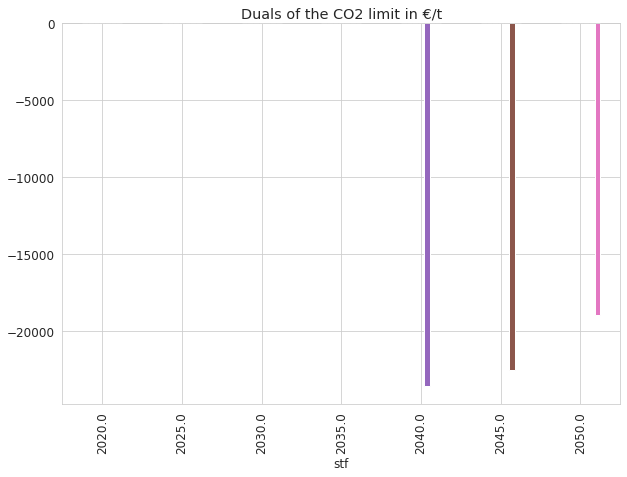

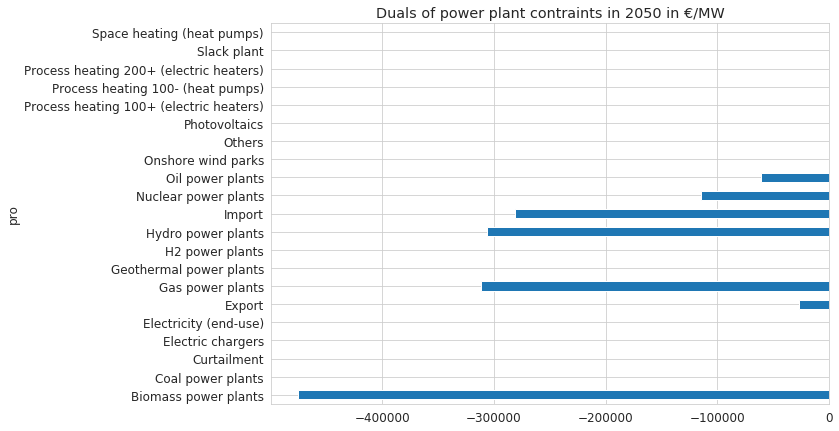

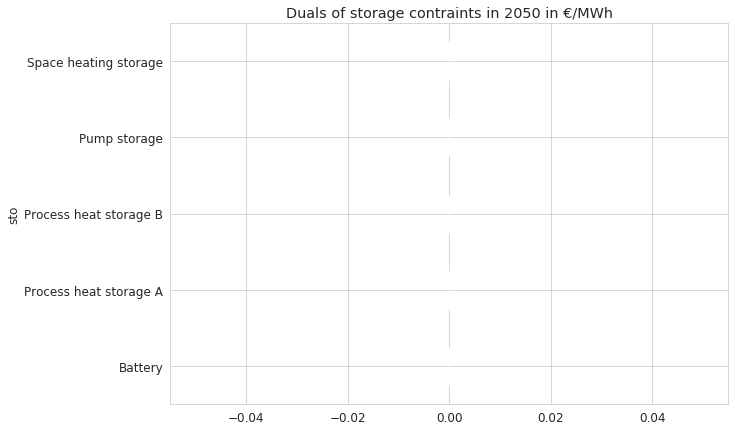

In [158]:
def dual_plots():

    co2_duals = {}
    for year in years:    
        co2_duals[f"{year}_co2_dual"] = df[year]["res_global_co2_limit"]

    pd.DataFrame(co2_duals).plot.bar(legend = None)
    plt.title("Duals of the CO2 limit in €/t")

    df[year]["res_process_capacity"].reset_index().dropna().set_index('pro').drop(['stf', 'sit'], axis = 1).plot.barh(legend = None)
    plt.title(f"Duals of power plant contraints in {year} in €/MW")

    df[year]["res_storage_capacity"].reset_index().set_index('sto').drop(['stf', 'sit'], axis = 1).plot.barh(legend = None)
    plt.title(f"Duals of storage contraints in {year} in €/MWh")
dual_plots()

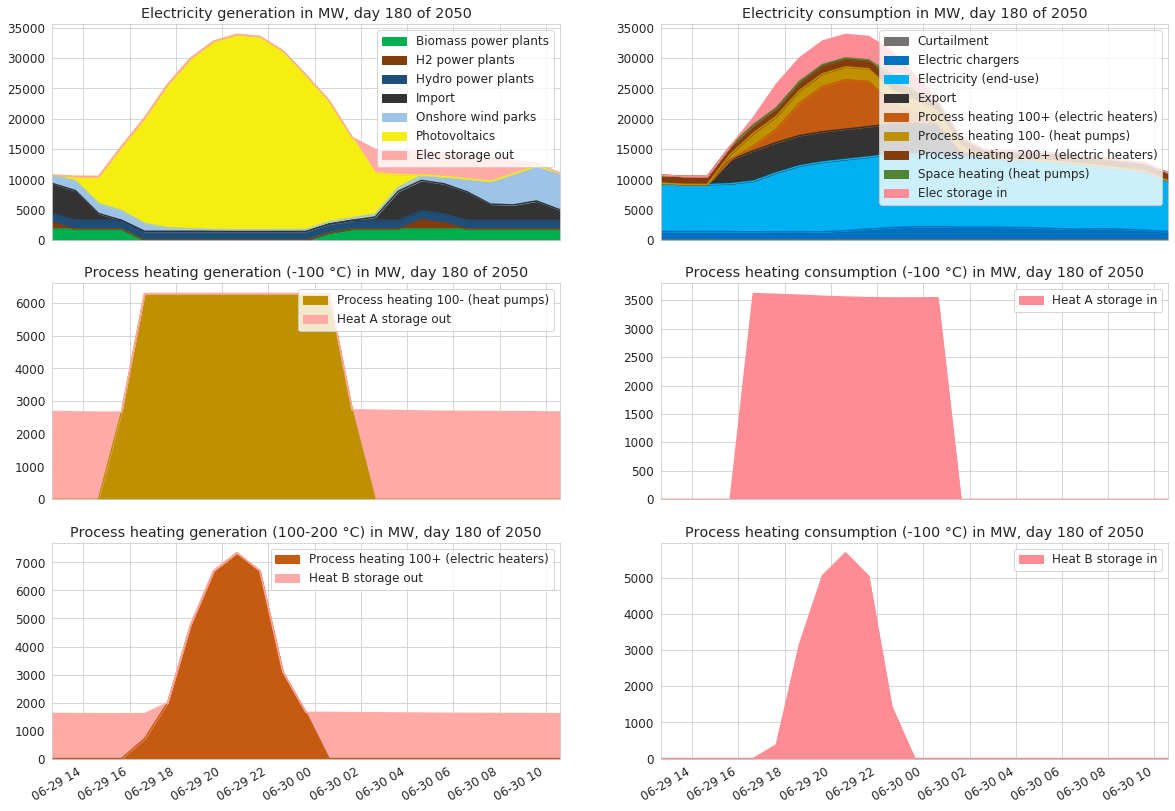

In [159]:
year = 2050
day = 180

def dayplot():

        # Electricity storage in and output
        sto_in = (df[year]['e_sto_in']
                .unstack()['Elec']
                .unstack()
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                .sum(axis = 1)
                )
                
        sto_out = (df[year]['e_sto_out']
                .unstack()['Elec']
                .unstack()
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                .sum(axis = 1))

        sto_out.name = "Elec storage out"
        sto_in.name = "Elec storage in"

        # Heat storage A in and output
        sto_in_phA = (df[year]['e_sto_in']
                .unstack()['Process heating A']
                .unstack()
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                .sum(axis = 1))
        sto_out_phA = (df[year]['e_sto_out']
                .unstack()['Process heating A']
                .unstack()
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                .sum(axis = 1))

        sto_out_phA.name = "Heat A storage out"
        sto_in_phA.name = "Heat A storage in"


        # Heat storage B in and output
        sto_in_phB = (df[year]['e_sto_in']
                .unstack()['Process heating B']
                .unstack()
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                .sum(axis = 1))
        sto_out_phB = (df[year]['e_sto_out']
                .unstack()['Process heating B']
                .unstack()
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                .sum(axis = 1))

        sto_out_phB.name = "Heat B storage out"
        sto_in_phB.name = "Heat B storage in"

        # Electricity generation
        gen = (df[year]['e_pro_out']
                .unstack()['Elec']
                .dropna()
                .unstack()
                .replace(0, np.nan).dropna(axis = 1, how = "all")
                .replace(np.nan, 0)
                .reorder_levels(['stf', 'sit', 't'])
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                )


        # Electricity consumption
        con = (df[year]['e_pro_in']
                .unstack()['Elec']
                .dropna()
                .unstack()
                .replace(0, np.nan).dropna(axis = 1, how = "all")
                .replace(np.nan, 0)
                .reorder_levels(['stf', 'sit', 't'])
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                )


        # Process heating A consumption
        con_phA = (df[year]['e_pro_out']
        .unstack()['Process heating A']
        .dropna()
        .unstack()
        .reorder_levels(['stf', 'sit', 't'])
        .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
        )


        # Process heating B consumption
        con_phB = (df[year]['e_pro_out']
        .unstack()['Process heating B']
        .dropna()
        .unstack()
        .reorder_levels(['stf', 'sit', 't'])
        .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
        )


        # Create case-study plot for electricity

        fig, axes = plt.subplots(3, 2, figsize = (20, 15), sharex = True)


        gen.join(pd.DataFrame(sto_out)).iloc[0 + day*24 : 23 + day*24, :].plot(ax = axes[0,0], kind = "area", color = [color_dict.get(x, '#333333') for x in (gen.join(pd.DataFrame(sto_out))).columns])
        axes[0,0].set_title(f"Electricity generation in MW, day {day} of {year}")
        axes[0,0].legend(loc = "upper right")

        con.join(pd.DataFrame(sto_in)).iloc[0 + day*24 : 23 + day*24, :].plot(ax = axes[0,1], kind = "area", color = [color_dict.get(x, '#333333') for x in (con.join(pd.DataFrame(sto_in))).columns])
        axes[0,1].set_title(f"Electricity consumption in MW, day {day} of {year}")
        axes[0,1].legend(loc = "upper right")


        con_phA.join(pd.DataFrame(sto_out_phA)).iloc[0 + day*24 : 23 + day*24, :].plot(ax = axes[1,0], kind = "area", color = [color_dict.get(x, '#333333') for x in (con_phA.join(pd.DataFrame(sto_out_phA))).columns])
        axes[1,0].set_title(f"Process heating generation (-100 °C) in MW, day {day} of {year}")
        axes[1,0].legend(loc = "upper right")

        (pd.DataFrame(sto_in_phA)).iloc[0 + day*24 : 23 + day*24, :].plot(ax = axes[1,1], kind = "area", color = [color_dict.get(x, '#333333') for x in (pd.DataFrame(sto_in_phA)).columns])
        axes[1,1].set_title(f"Process heating consumption (-100 °C) in MW, day {day} of {year}")
        axes[1,1].legend(loc = "upper right")


        con_phB.join(pd.DataFrame(sto_out_phB)).iloc[0 + day*24 : 23 + day*24, :].plot(ax = axes[2,0], kind = "area", color = [color_dict.get(x, '#333333') for x in con_phB.join(pd.DataFrame(sto_out_phB)).columns])
        axes[2,0].set_title(f"Process heating generation (100-200 °C) in MW, day {day} of {year}")
        axes[2,0].legend(loc = "upper right")

        (pd.DataFrame(sto_in_phB)).iloc[0 + day*24 : 23 + day*24, :].plot(ax = axes[2,1], kind = "area", color = [color_dict.get(x, '#333333') for x in (pd.DataFrame(sto_in_phB)).columns])
        axes[2,1].set_title(f"Process heating consumption (-100 °C) in MW, day {day} of {year}")
        axes[2,1].legend(loc = "upper right")

dayplot()

In [160]:
def fourier_plots():

    def fourier_plot(data, comm, tech):
    
        # Convert storage level data
        df = (data['e_sto_con']
        .unstack()[comm]
        .dropna()
        .unstack()
        .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8761))
        )
        
        # Calculate SOC, and de-mean the timeseries data
        soc = (df[tech] - np.mean(df[tech])) / np.max(df[tech])
        n = len(soc)
        # Calculate FFT vector, power density vector, and frequency
        fhat = np.fft.fft(soc, n)
        PSD = fhat * np.conj(fhat) / n
        freq = (1/n) * np.arange(n)

        # Create a pairplot with the modified SOC and FFT components
        fig, axs = plt.subplots(2, 1)

        plt.sca(axs[0])
        plt.plot(soc)

        plt.sca(axs[1])
        plt.plot(freq[0:200], PSD[0:200])

        plt.suptitle(f"Seasonality of {tech}")

    fourier_plot(df[year], 'Process heating A', 'Process heat storage A')
    fourier_plot(df[year], 'Process heating B', 'Process heat storage B')
    fourier_plot(df[year], 'Space heating', 'Space heating storage')
    fourier_plot(df[year], 'Elec', 'Pump storage')
    fourier_plot(df[year], 'Elec', 'Battery')

#fourier_plots()

In [161]:
sto_c_y = {}
sto_p_y = {}

for year in years:
    sto_c_y[year] = df[year]['cap_sto_c'].unstack()
    sto_p_y[year] = df[year]['cap_sto_p'].unstack()

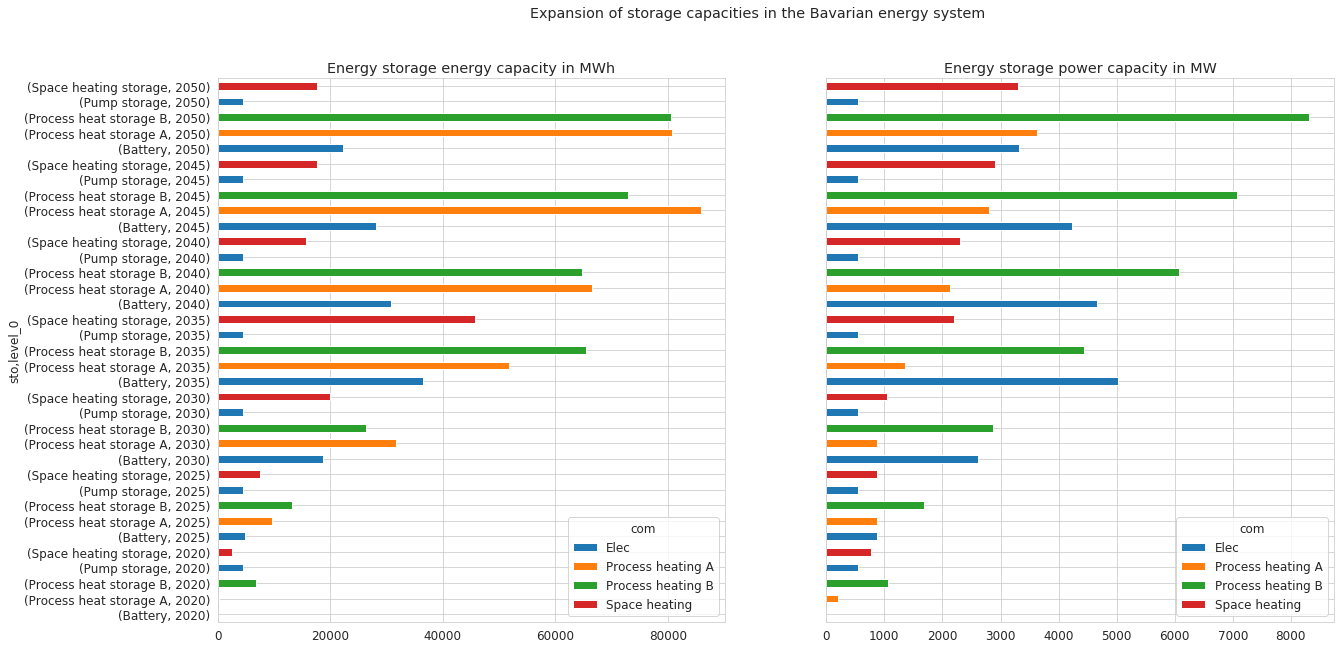

In [162]:
def storage_plot():

    sto_c_y = {}
    sto_p_y = {}

    for year in years:
        sto_c_y[year] = df[year]['cap_sto_c'].unstack()
        sto_p_y[year] = df[year]['cap_sto_p'].unstack()

    fig, axes = plt.subplots(1, 2, figsize = (20, 10), sharey=True)

    pd.concat(sto_c_y).reset_index().set_index(['sto', 'level_0']).drop(['stf', 'sit'], axis = 1).plot(ax = axes[0], kind = 'barh', stacked = True)
    axes[0].set_title("Energy storage energy capacity in MWh")

    pd.concat(sto_p_y).reset_index().set_index(['sto', 'level_0']).drop(['stf', 'sit'], axis = 1).plot(ax = axes[1], kind = 'barh', stacked = True)
    axes[1].set_title("Energy storage power capacity in MW")

    fig.suptitle("Expansion of storage capacities in the Bavarian energy system")

storage_plot()

In [163]:
def energy_plot():

    # Creating dataframes for the list of processes

    gen = (df[years[-1]]['e_pro_out']
    .unstack()['Elec']
    .dropna()
    .unstack()
    )

    con = (df[years[-1]]['e_pro_in']
        .unstack()['Elec']
        .dropna()
        .unstack()
        )
    
    fig, axes = plt.subplots(2, 2, figsize = (20,15), sharex = True)

    gen_y = {}

    for year in years:
        gen_y[year] = (df[year]['e_pro_out']
            .unstack()['Elec']
            .dropna()
            .unstack()
            .replace(0, np.nan).dropna(axis = 1, how = "all")
            .replace(np.nan, 0)
            .reorder_levels(['stf', 'sit', 't'])
            .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
            .resample('Y').sum()
            )
        
    to_plot = ((pd.concat(gen_y, sort = True) / 1e6)
    .reset_index()
    .set_index('level_0')
    .drop(['level_1'], axis = 1)
    )
    to_plot.plot(ax = axes[0,0], kind = 'bar', stacked = 'True', color = [color_dict.get(x, '#333333') for x in to_plot.columns])
    axes[0, 0].set_title("Generation in TWh")

    con_y = {}

    for year in years:
        con_y[year] = (df[year]['e_pro_in']
            .unstack()['Elec']
            .dropna()
            .unstack()
            .replace(0, np.nan).dropna(axis = 1, how = "all")
            .replace(np.nan, 0)
            .reorder_levels(['stf', 'sit', 't'])
            .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
            .resample('Y').sum()
            )
        
    to_plot = ((pd.concat(con_y, sort = True) / 1e6)
    .reset_index()
    .set_index('level_0')
    .drop(['level_1'], axis = 1)
    )
    to_plot.plot(ax = axes[0,1], kind = 'bar', stacked = 'True', color = [color_dict.get(x, '#333333') for x in to_plot.columns])
    axes[0, 1].set_title("Consumption in TWh")



    gen_cap_y = {}
    con_cap_y = {}

    for year in years:
        gen_cap_y[year] = df[year]['cap_pro'].unstack()[gen.columns].drop(['Curtailment', 'Slack plant', 'Import'], axis = 1)
        con_cap_y[year] = df[year]['cap_pro'].unstack()[con.columns].drop(['Curtailment', 'Export'], axis = 1)

    to_plot = (pd.concat(gen_cap_y, sort = True)
    .reset_index()
    .drop(['stf', 'sit'], axis = 1)
    .set_index('level_0')
    )
    to_plot.plot(ax = axes[1, 0], kind = 'bar', stacked = True, color = [color_dict.get(x, '#333333') for x in to_plot.columns])
    axes[1, 0].set_title("Generation fleet in MW")


    to_plot = (pd.concat(con_cap_y, sort = True)
    .reset_index()
    .drop(['stf', 'sit'], axis = 1)
    .set_index('level_0')
    )
    to_plot.plot(ax = axes[1,1], kind = 'bar', stacked = True, color = [color_dict.get(x, '#333333') for x in to_plot.columns])
    axes[1, 1].set_title("Consumption fleet in MW")

    fig.suptitle("Expansion of consumption and generation characteristics of the Bavarian energy system")

#energy_plot()

Text(0.5, 0.98, 'Expansion of consumption and generation characteristics of the Bavarian energy system')

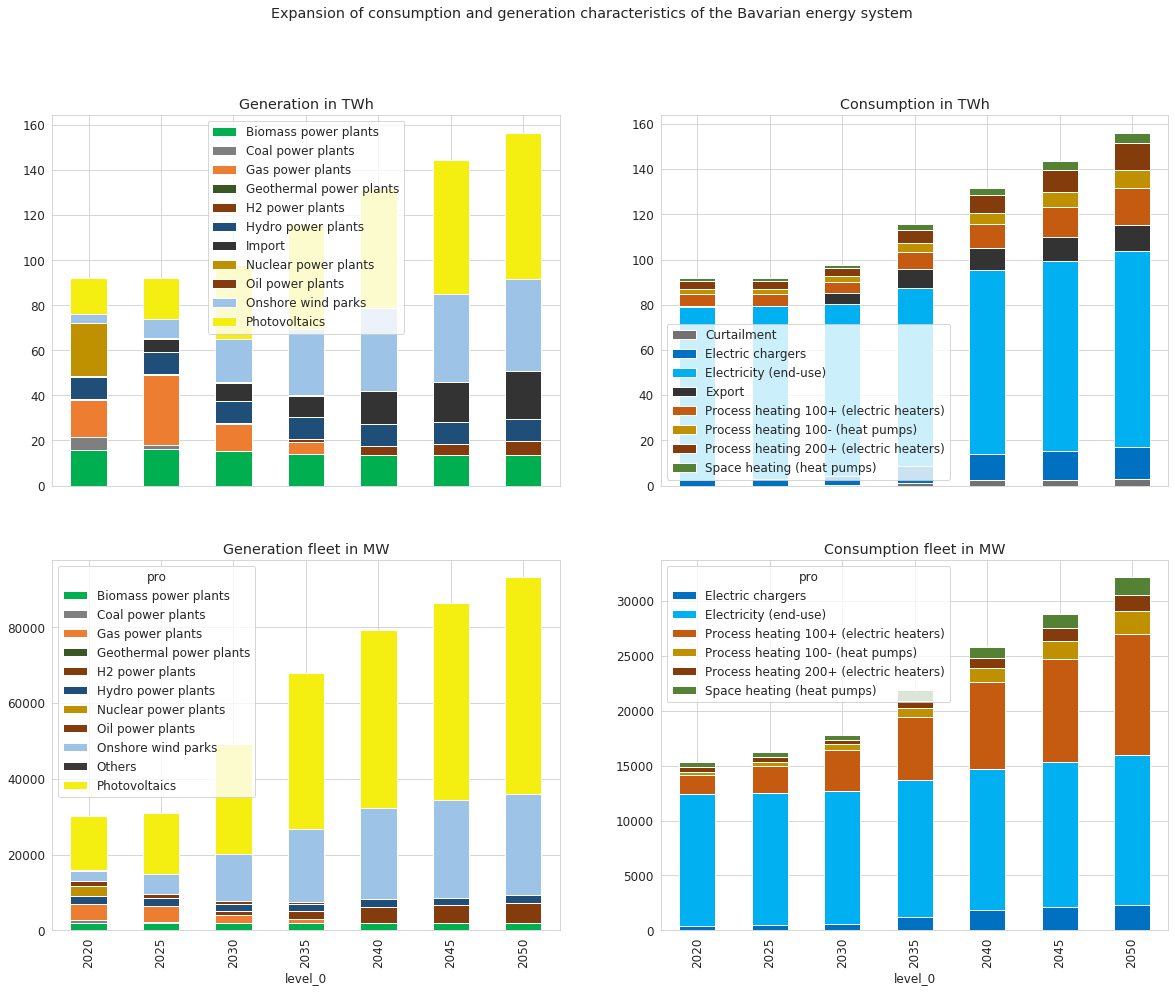

In [164]:
# Creating dataframes for the list of processes

gen = (df[years[-1]]['e_pro_out']
.unstack()['Elec']
.dropna()
.unstack()
)

con = (df[years[-1]]['e_pro_in']
    .unstack()['Elec']
    .dropna()
    .unstack()
    )

fig, axes = plt.subplots(2, 2, figsize = (20,15), sharex = True)

gen_y = {}

for year in years:
    gen_y[year] = (df[year]['e_pro_out']
        .unstack()['Elec']
        .dropna()
        .unstack()
        .replace(0, np.nan).dropna(axis = 1, how = "all")
        .replace(np.nan, 0)
        .reorder_levels(['stf', 'sit', 't'])
        .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
        .resample('Y').sum()
        )
    
to_plot = ((pd.concat(gen_y, sort = True) / 1e6)
.reset_index()
.set_index('level_0')
.drop(['level_1'], axis = 1)
)
to_plot.plot(ax = axes[0,0], kind = 'bar', stacked = 'True', color = [color_dict.get(x, '#333333') for x in to_plot.columns])
axes[0, 0].set_title("Generation in TWh")

con_y = {}

for year in years:
    con_y[year] = (df[year]['e_pro_in']
        .unstack()['Elec']
        .dropna()
        .unstack()
        .replace(0, np.nan).dropna(axis = 1, how = "all")
        .replace(np.nan, 0)
        .reorder_levels(['stf', 'sit', 't'])
        .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
        .resample('Y').sum()
        )
    
to_plot = ((pd.concat(con_y, sort = True) / 1e6)
.reset_index()
.set_index('level_0')
.drop(['level_1'], axis = 1)
)
to_plot.plot(ax = axes[0,1], kind = 'bar', stacked = 'True', color = [color_dict.get(x, '#333333') for x in to_plot.columns])
axes[0, 1].set_title("Consumption in TWh")



gen_cap_y = {}
con_cap_y = {}

for year in years:
    gen_cap_y[year] = df[year]['cap_pro'].unstack()[gen.columns].dropna().drop(['Curtailment', 'Slack plant', 'Import'], axis = 1)
    con_cap_y[year] = df[year]['cap_pro'].unstack()[con.columns].dropna().drop(['Curtailment', 'Export'], axis = 1)

to_plot = (pd.concat(gen_cap_y, sort = True)
.reset_index()
.drop(['stf', 'sit'], axis = 1)
.set_index('level_0')
)
to_plot.plot(ax = axes[1, 0], kind = 'bar', stacked = True, color = [color_dict.get(x, '#333333') for x in to_plot.columns])
axes[1, 0].set_title("Generation fleet in MW")


to_plot = (pd.concat(con_cap_y, sort = True)
.reset_index()
.drop(['stf', 'sit'], axis = 1)
.set_index('level_0')
)
to_plot.plot(ax = axes[1,1], kind = 'bar', stacked = True, color = [color_dict.get(x, '#333333') for x in to_plot.columns])
axes[1, 1].set_title("Consumption fleet in MW")

fig.suptitle("Expansion of consumption and generation characteristics of the Bavarian energy system")

Text(0.5, 0.98, 'Expansion of energy generation in the Bavarian energy system')

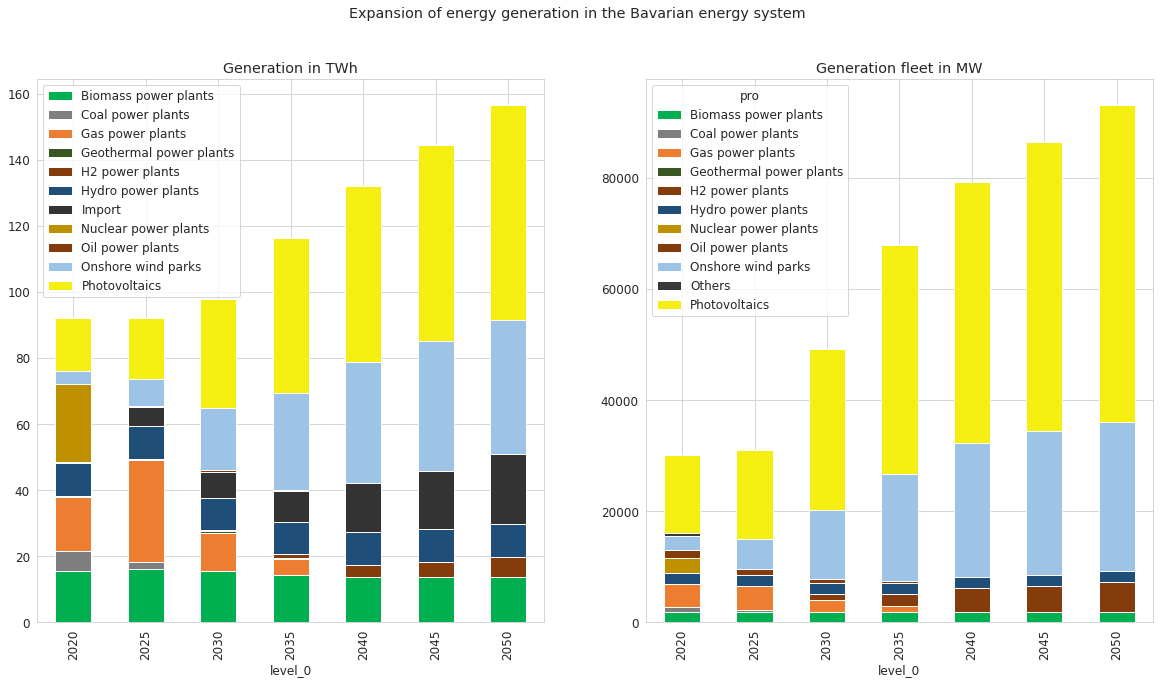

In [165]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

fig, axes = plt.subplots(1, 2, figsize = (20,10))

to_plot = ((pd.concat(gen_y, sort = True) / 1e6)
.reset_index()
.set_index('level_0')
.drop(['level_1'], axis = 1)
)
to_plot.plot(ax = axes[0], kind = 'bar', stacked = 'True', color = [color_dict.get(x, '#333333') for x in to_plot.columns])
axes[0].set_title("Generation in TWh")


to_plot = (pd.concat(gen_cap_y, sort = True)
.reset_index()
.drop(['stf', 'sit'], axis = 1)
.set_index('level_0')
)
to_plot.plot(ax = axes[1], kind = 'bar', stacked = True, color = [color_dict.get(x, '#333333') for x in to_plot.columns])
axes[1].set_title("Generation fleet in MW")

fig.suptitle("Expansion of energy generation in the Bavarian energy system")

Text(0.5, 0.98, 'Expansion of energy consumption in the Bavarian energy system')

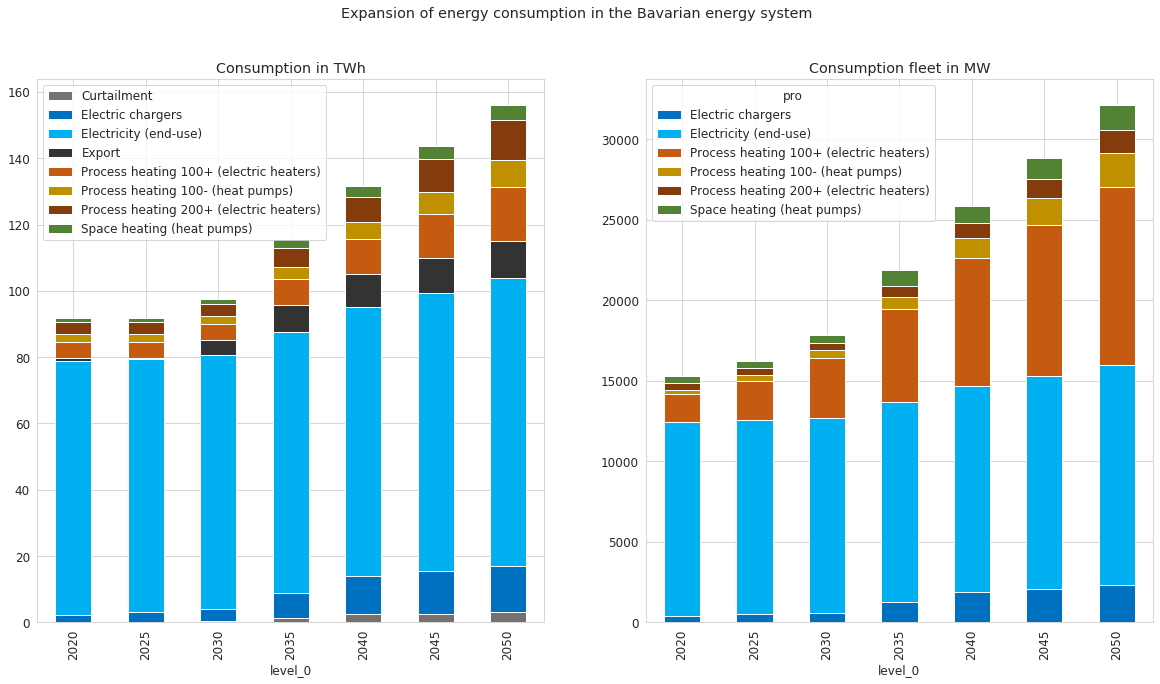

In [166]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

fig, axes = plt.subplots(1, 2, figsize = (20,10))

to_plot = ((pd.concat(con_y, sort = True) / 1e6)
.reset_index()
.set_index('level_0')
.drop(['level_1'], axis = 1)
)
to_plot.plot(ax = axes[0], kind = 'bar', stacked = 'True', color = [color_dict.get(x, '#333333') for x in to_plot.columns])
axes[0].set_title("Consumption in TWh")


to_plot = (pd.concat(con_cap_y, sort = True)
.reset_index()
.drop(['stf', 'sit'], axis = 1)
.set_index('level_0')
)
to_plot.plot(ax = axes[1], kind = 'bar', stacked = True, color = [color_dict.get(x, '#333333') for x in to_plot.columns])
axes[1].set_title("Consumption fleet in MW")

fig.suptitle("Expansion of energy consumption in the Bavarian energy system")

In [167]:
(pd.concat(con_y, sort = True) / 1e6)

,,Curtailment,Electric chargers,Electricity (end-use),Export,Process heating 100+ (electric heaters),Process heating 100- (heat pumps),Process heating 200+ (electric heaters),Space heating (heat pumps)
2020,2020-12-31,NaN,2.273684,76.53,0.836088,4.940882,2.448654,3.6725,1.131317
2025,2025-12-31,NaN,2.968421,76.53,0.118131,4.947284,2.459535,3.6725,1.145539
2030,2030-12-31,0.335945,3.663158,76.53,4.538257,4.971467,2.469422,3.6725,1.250798
2035,2035-12-31,1.198133,7.589474,78.81,8.135003,7.752523,3.844217,5.7200,2.563051
2040,2040-12-31,2.413622,11.515789,81.32,9.923405,10.386241,5.164060,7.6725,3.162692
2045,2045-12-31,2.574644,12.768421,83.99,10.590080,13.371938,6.651434,9.8825,3.934779
2050,2050-12-31,2.971373,14.010526,86.83,11.377942,16.292464,8.105990,12.0450,4.564374


In [168]:
(pd.concat(gen_cap_y, sort = True))

,,pro,Biomass power plants,Coal power plants,Gas power plants,Geothermal power plants,H2 power plants,Hydro power plants,Nuclear power plants,Oil power plants,Onshore wind parks,Others,Photovoltaics
,stf,sit,,,,,,,,,,,
2020,2020.0,Bayern,1848.0,839.0,4219.00,46.0,0.000000,1981.0,2698.0,1388.0,2533.000000,460.0,14035.000000
2025,2025.0,Bayern,1848.0,419.5,4219.00,46.0,0.000000,1981.0,0.0,1041.0,5414.465936,0.0,16095.806950
2030,2030.0,Bayern,1848.0,0.0,2109.50,46.0,1054.750000,1981.0,0.0,694.0,12455.220157,0.0,28926.460487
2035,2035.0,Bayern,1848.0,0.0,1054.75,46.0,2109.500000,1981.0,0.0,347.0,19335.637309,0.0,41119.807365
2040,2040.0,Bayern,1848.0,0.0,0.00,46.0,4367.469315,1981.0,0.0,0.0,24113.500424,0.0,46943.587628
2045,2045.0,Bayern,1848.0,0.0,0.00,46.0,4714.513300,1981.0,0.0,0.0,25915.456128,0.0,51926.811453
2050,2050.0,Bayern,1848.0,0.0,0.00,46.0,5400.754247,1981.0,0.0,0.0,26739.340875,0.0,57164.362479


In [169]:
((pd.concat(gen_y, sort = True) / 1e6))

,,Biomass power plants,Coal power plants,Gas power plants,Geothermal power plants,H2 power plants,Hydro power plants,Import,Nuclear power plants,Oil power plants,Onshore wind parks,Photovoltaics
2020,2020-12-31,15.636272,6.064955,16.136530,0.40296,NaN,9.86238,0.472398,23.549135,0.020586,3.851944,15.971466
2025,2025-12-31,16.185276,1.932206,31.043893,0.40296,NaN,9.86238,5.618985,NaN,0.436577,8.233801,18.316610
2030,2030-12-31,15.432782,NaN,11.693726,0.40296,0.299030,9.86238,7.700145,NaN,0.606378,18.940704,32.917561
2035,2035-12-31,14.189603,NaN,4.947170,0.40296,1.002541,9.86238,9.243017,NaN,0.423464,29.403783,46.793273
2040,2040-12-31,13.575863,NaN,NaN,NaN,3.848310,9.86238,14.778161,NaN,NaN,36.669499,53.420584
2045,2045-12-31,13.705761,NaN,NaN,NaN,4.638611,9.86238,17.612178,NaN,NaN,39.409741,59.091363
2050,2050-12-31,13.711466,NaN,NaN,NaN,6.101912,9.86238,21.273692,NaN,NaN,40.662625,65.051560


In [170]:
pd.concat(sto_c_y)

com                                                Elec  Process heating A  \
     stf    sit    sto                                                       
2020 2020.0 Bayern Battery                     0.000000                NaN   
                   Process heat storage A           NaN         229.951458   
                   Process heat storage B           NaN                NaN   
                   Pump storage             4500.000000                NaN   
                   Space heating storage            NaN                NaN   
2025 2025.0 Bayern Battery                  4871.233981                NaN   
                   Process heat storage A           NaN        9575.373598   
                   Process heat storage B           NaN                NaN   
                   Pump storage             4500.000000                NaN   
                   Space heating storage            NaN                NaN   
2030 2030.0 Bayern Battery                 18723.825075                NaN   
                   Process heat storage A           NaN       31633.340661   
                   Process heat storage B           NaN                NaN   
                   Pump storage             4500.000000                NaN   
                   Space heating storage            NaN                NaN   
2035 2035.0 Bayern Battery                 36389.606630                NaN   
                   Process heat storage A           NaN       51771.463730   
                   Process heat storage B           NaN                NaN   
                   Pump storage             4500.000000                NaN   
                   Space heating storage            NaN                NaN   
2040 2040.0 Bayern Battery                 30759.357037                NaN   
                   Process heat storage A           NaN       66548.135311   
                   Process heat storage B           NaN                NaN   
                   Pump storage             4500.000000                NaN   
                   Space heating storage            NaN                NaN   
2045 2045.0 Bayern Battery                 28129.669743                NaN   
                   Process heat storage A           NaN       85785.071392   
                   Process heat storage B           NaN                NaN   
                   Pump storage             4500.000000                NaN   
                   Space heating storage            NaN                NaN   
2050 2050.0 Bayern Battery                 22249.549583                NaN   
                   Process heat storage A           NaN       80670.081490   
                   Process heat storage B           NaN                NaN   
                   Pump storage             4500.000000                NaN   
                   Space heating storage            NaN                NaN   

com                                        Process heating B  Space heating  
     stf    sit    sto                                                       
2020 2020.0 Bayern Battery                               NaN            NaN  
                   Process heat storage A                NaN            NaN  
                   Process heat storage B        6807.078413            NaN  
                   Pump storage                          NaN            NaN  
                   Space heating storage                 NaN    2601.034461  
2025 2025.0 Bayern Battery                               NaN            NaN  
                   Process heat storage A                NaN            NaN  
                   Process heat storage B       13231.829588            NaN  
                   Pump storage                          NaN            NaN  
                   Space heating storage                 NaN    7470.666533  
2030 2030.0 Bayern Battery                               NaN            NaN  
                   Process heat storage A                NaN            NaN  
                   Pr